In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import re
sns.set()

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(dirname, _,filename, os.path.join(dirname, filename))

current_directory = os.getcwd()

print("The current working directory is:", current_directory)
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic [] train.csv /kaggle/input/titanic/train.csv
/kaggle/input/titanic [] test.csv /kaggle/input/titanic/test.csv
/kaggle/input/titanic [] gender_submission.csv /kaggle/input/titanic/gender_submission.csv
The current working directory is: /kaggle/working


In [2]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

# Question and problem definition

## Acquire data

In [3]:
train_df = pd.read_csv('../input/titanic/train.csv')
train_df.name ='train_df'
test_df = pd.read_csv('../input/titanic/test.csv')
test_df.name = 'test_df'
combine = [train_df, test_df]

In [4]:
print(train_df.columns.values)

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']


* Categorical
    * Nominal
        * Name
        * Sex
        * Ticket
        * Cabin
        * Embarked
    * Ordinal
        * Pclass
        * PassengerId 
* Numerical
    * Continuous
        * Age 
        * Fare
    * Discrete
        * Survived 
        * SibSp 
        * Parch

**Which features are mixed data types?**

Numerical, alphanumeric data within same feature. These are candidates for correcting goal.

Ticket is a mix of numeric and alphanumeric data types. Cabin is alphanumeric.


**errors or typos?**

This is **harder to review** for a large dataset, however reviewing a few samples from a smaller dataset may just tell us outright, which features may require correcting.

Name feature may contain errors or typos as there are several ways used to describe a name including titles, round brackets, and quotes used for alternative or short names. **i.e. Gomez, Dr. Josue**

**blank, null or empty values?**

These will require correcting.

Cabin > Age > Embarked features contain a number of null values in that order for the training dataset.<br>
Cabin > Age are incomplete in case of test dataset.

**What are the data types for various features?**

Helping us during converting goal.

Seven features are integer or floats. Six in case of test dataset.
Five features are strings (object).

**What is the distribution of numerical feature values across the samples?**

This helps us determine, among other early insights, how representative is the training dataset of the actual problem domain.

* Total samples are 891 or 40\% of the actual number of passengers on board the Titanic (2,224).
* **Survived is a categorical feature with 0 or 1 values.**
* Around 38\% samples survived representative of the actual survival rate at 32\%.
* Most passengers (\> 75\%) did not travel with parents or children.
* Nearly 30\% of the passengers had siblings and/or spouse aboard.
* Fares varied significantly with few passengers (\<1\%) paying as high as \$512.
* Few elderly passengers (\<1%) within age range 65-80.

In [5]:
train_df.describe()
# Review survived rate using `percentiles=[.61, .62]` knowing our problem description mentions 38% survival rate.
# Review Parch distribution using `percentiles=[.75, .8]`
# SibSp distribution `[.68, .69]`
# Age and Fare `[.1, .2, .3, .4, .5, .6, .7, .8, .9, .99]`

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


**categorical features?**

* Names are unique across the dataset (count=unique=891)
* Sex variable as two possible values with 65% male (top=male, freq=577/count=891).
* Cabin values have several dupicates across samples. Alternatively several passengers shared a cabin.
* Embarked takes three possible values. S port used by most passengers (top=S)
* Ticket feature has high ratio (22%) of duplicate values (unique=681).

In [6]:
train_df.describe(include=['O']) # 'O'(Python) objects  

# link: https://numpy.org/doc/stable/reference/arrays.dtypes.html

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


## Assumtions based on data analysis
We arrive at following assumptions based on data analysis done so far. We may ***validate*** these assumptions further before taking appropriate actions.

**Workflow goals**

* Classifying<br>
We may also add to our assumptions based on the problem description noted earlier.<br>
    1. Women (Sex=female) were more likely to have survived.<br>
    2. Children (Age\<?) were more likely to have survived.<br>
    3. The upper-class passengers (Pclass=1) were more likely to have survived. 
* Correlating<br>We want to know how well does each feature correlate with Survival. We want to do this early in our project and match these quick correlations with modelled correlations later in the project.
* Completing
    1. Complete Age feature as it is **definitely** correlated to survival.
    2. Complete Embarked. it may correlate with survival or another feature.
* Correcting
    1. Ticket may - dropped - high ratio of duplicates (22%) and may not be a correlation Ticket and survival.
    2. Cabin may - dropped - highly incomplete or many null values.
    3. PassengerId - dropped - does not contribute to survival.
    4. Name - dropped - relatively non-standard, may not contribute directly to survival.
* Creating
    1. **Family** based on **Parch** and **SibSp**.
    2. engineer the Name to extract **Title** as a new feature.
    3. **Age bands**. continous -> ordinal categorical feature.
    4. **Fare range** feature.
* Charting
* Converting

## Analyse by Pivoting features
To confirm some of our observations and assumptions, we can quickly analyze our feature correlations by **pivoting features** against each other. 
We can *only* do so at this stage for features which *do not have any empty values*. It also makes sense doing so only for features which are *categorical (Sex), ordinal (Pclass) or discrete (SibSp, Parch)* type.

**Pclass** significant correlation (>0.5) among Pclass=1 and Survived (classifying #3). => include in our model.<br>
**Sex** We confirm Sex=female had very high survival rate at 74% (classifying #1).<br>
**SibSp and Parch** These features have zero correlation for certain values. best to derive a set of features from these individual features (creating #1).

In [7]:
train_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [8]:
train_df[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [9]:
train_df[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [10]:
train_df[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


## Analyze by visualizing data
### Correlating numerical features

*histogram chart* for analyzing **continous numerical** variables like Age where banding or ranges will help identify useful patterns. The histogram can indicate distribution of samples using automatically defined bins or equally ranged bands. This helps us answer questions relating to specific bands (Did infants have better survival rate?)

**Observations.**

* Infants (Age <=4) had high survival rate.
* Oldest passengers (Age = 80) survived.
* Large number of 15-25 year olds did not survive.
* Most passengers are in 15-35 age range.

**Decisions.**

This simple analysis confirms our assumptions as decisions for subsequent workflow stages.

* Age (our assumption classifying #2) in our model training.
* Complete the Age feature (completing #1).
* band age groups (creating #3).

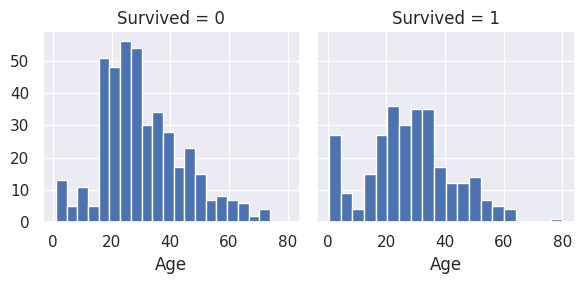

In [11]:
g = sns.FacetGrid(train_df, col='Survived') # Makes the matrix of plots, like subplots
g.map(plt.hist, 'Age', bins=20)

### Correlating numerical and ordinal features
We can combine multiple features for identifying correlations using a single plot. This can be done with numerical and categorical features which have numeric values.

**Observations.**

* Pclass=3 had most passengers, however most did not survive. Confirms our classifying assumption #2.
Infant passengers in Pclass=2 and Pclass=3 mostly survived. Further qualifies our classifying assumption #2.
* Most passengers in Pclass=1 survived. Confirms our classifying assumption #3.
* Pclass varies in terms of Age distribution of passengers.

**Decisions.**

* Consider Pclass for model training.

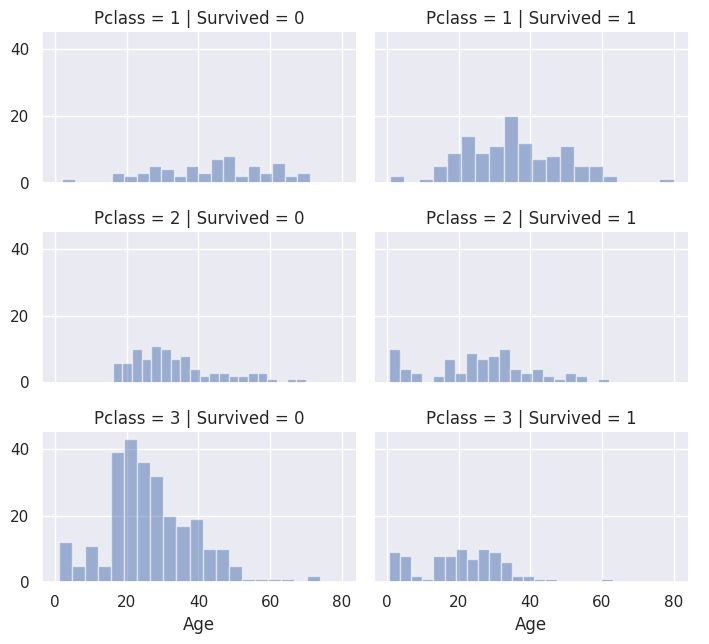

In [12]:
# grid = sns.FacetGrid(train_df, col='Pclass', hue='Survived')
grid = sns.FacetGrid(train_df, col='Survived', row='Pclass', height=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

## Correlating categorical features¶
Now we can correlate categorical features with our solution goal.

**Observations**.

* Female passengers had much better survival rate than males. Confirms classifying ( #1).
* This could be a correlation between Pclass and Embarked and in turn Pclass and Survived, not necessarily direct correlation between Embarked and Survived.
* Males had better survival rate in Pclass=3 when compared with Pclass=2 for C and Q ports. Completing ( #2).
* Ports of embarkation have varying survival rates for Pclass=3 and among male passengers. Correlating ( #1).
**Decisions**.

* Add Sex feature to model training.
* Complete and add Embarked feature to model training.

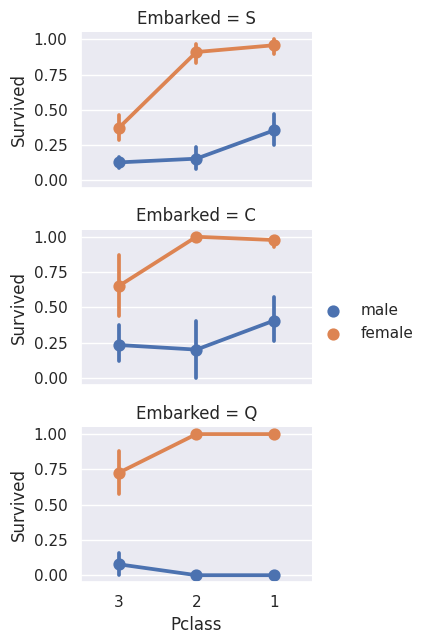

In [13]:
# grid = sns.FacetGrid(train_df, col='Embarked')
grid = sns.FacetGrid(train_df, row='Embarked', height=2.2, aspect=1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep',hue_order=['male','female'],order=[3,2,1])
grid.add_legend()

## Correlating categorical and numerical features¶

We may also want to correlate categorical features (with non-numeric values) and numeric features. We can consider correlating 'Embarked' (Categorical non-numeric), Sex (Categorical non-numeric), Fare (Numeric continuous), with 'Survived' (Categorical numeric).

**Observations**.

* Higher fare paying passengers had better survival. Confirms our assumption for creating (#4) fare ranges.
* Port of embarkation correlates with survival rates. Confirms correlating (#1) and completing (#2).
**Decisions**.

Consider banding Fare feature.

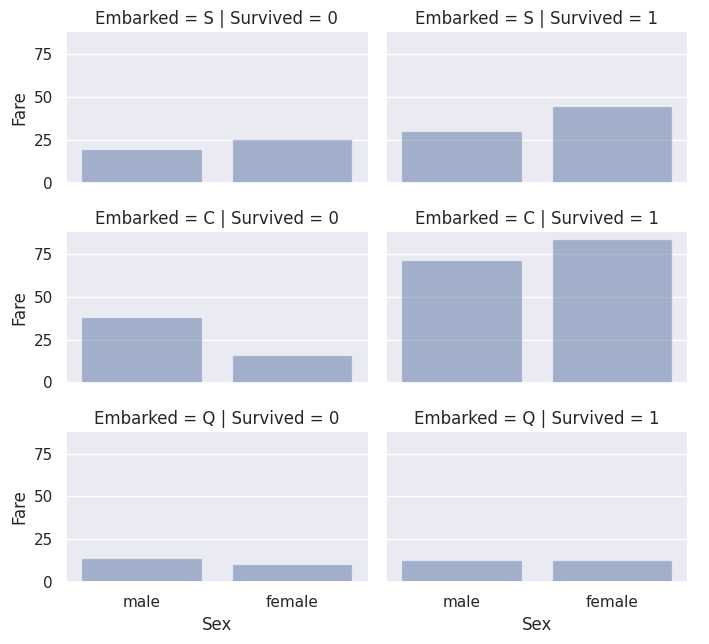

In [14]:
# grid = sns.FacetGrid(train_df, col='Embarked', hue='Survived', palette={0: 'k', 1: 'w'})
grid = sns.FacetGrid(train_df, row='Embarked', col='Survived', height=2.2, aspect=1.6)
grid.map(sns.barplot, 'Sex', 'Fare', alpha=.5, errorbar=None,order=['male','female'])
grid.add_legend()

## Wrangle data

We have collected several assumptions and decisions regarding our datasets and solution requirements. So far we did not have to change a single feature or value to arrive at these. Let us now execute our decisions and assumptions for correcting, creating, and completing goals.

**Correcting by dropping features**

This is a good starting goal to execute. By dropping features we are dealing with fewer data points. Speeds up our notebook and eases the analysis.

Based on our assumptions and decisions we want to drop the Cabin (correcting #2) and Ticket (correcting #1) features.

Note that where applicable we perform operations on both training and testing datasets together to stay consistent.

In [15]:
print("Before:", train_df.shape, test_df.shape, combine[0].shape, combine[1].shape)
try:
    train_df = train_df.drop(['Ticket', 'Cabin'], axis=1)
    test_df = test_df.drop(['Ticket', 'Cabin'], axis=1)
    print("After:", train_df.shape, test_df.shape, combine[0].shape, combine[1].shape)
except:
    print('Ticket and Cabin columns were already droped')
combine = [train_df, test_df]

Before: (891, 12) (418, 11) (891, 12) (418, 11)
After: (891, 10) (418, 9) (891, 12) (418, 11)


## Creating new feature extracting from existing
We want to analyze if Name feature can be engineered to extract titles and test correlation between titles and survival, before dropping Name and PassengerId features.

In the following code we extract **`Title`** feature using ***regular expressions.*** The RegEx pattern (\w+\.) matches the first word which ends with a dot character within Name feature. The expand=False flag returns a DataFrame.

**Observations**.

When we plot `Title`, `Age`, and `Survived`, we note the following observations.

* Most titles band Age groups accurately. For example: Master title has Age mean of 5 years.
* Survival among Title Age bands varies slightly.
* Certain titles mostly survived (Mme, Lady, Sir) or did not (Don, Rev, Jonkheer).

**Decision**.

We decide to retain the new `Title` feature for model training.

In [16]:
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(train_df['Title'], train_df['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


We can replace many titles with a more common name or classify them as `Rare`.

In [17]:
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',
                                                 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
train_df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


We can convert the categorical titles to ordinal.

In [18]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,1


Now we can safely drop the Name feature from training and testing datasets. We also do not need the PassengerId feature in the training dataset.... (I don't like this, Surname could give some information about why some Parents did not survive and the kids did)

In [19]:
train_df = train_df.drop(['Name', 'PassengerId'], axis=1)
test_df = test_df.drop(['Name'], axis=1)
combine = [train_df, test_df]
train_df.shape, test_df.shape

((891, 9), (418, 9))

### Converting a categorical feature

Now we can convert features which contain strings to numerical values. This is required by most model algorithms. Doing so will also help us in achieving the feature completing goal.

Let us start by converting Sex feature to a new feature called Gender where female=1 and male=0.

In [20]:
for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22.0,1,0,7.2500,S,1
1,1,1,1,38.0,1,0,71.2833,C,3
2,1,3,1,26.0,0,0,7.9250,S,2
3,1,1,1,35.0,1,0,53.1000,S,3
4,0,3,0,35.0,0,0,8.0500,S,1


### Completing a numerical continuous feature¶
Now we should start estimating and completing features with missing or null values. We will first do this for the **Age** feature.

We can consider three methods to complete a numerical continuous feature.

* A simple way is to generate random numbers between mean and standard deviation.

* More accurate way of guessing missing values is to use other correlated features. In our case we note correlation among **Age**, **Gender**, and **Pclass**. Guess **Age** values using median values for **Age** across sets of **Pclass** and **Gender** feature combinations. So, median **Age** for Pclass=1 and Gender=0, Pclass=1 and Gender=1, and so on...

* Combine methods 1 and 2. So instead of guessing age values based on median, use random numbers between mean and standard deviation, based on sets of Pclass and Gender combinations.

Method 1 and 3 will introduce random noise into our models. The results from multiple executions might vary. We will prefer method 2.

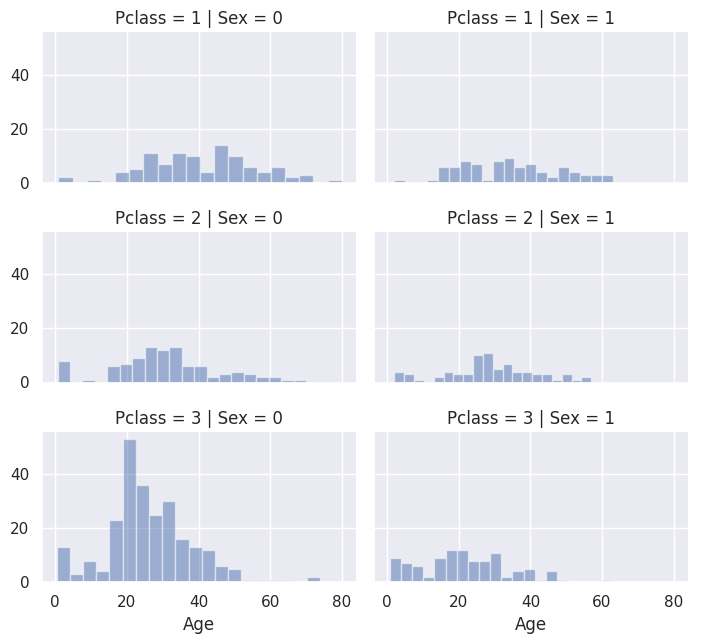

In [21]:
# grid = sns.FacetGrid(train_df, col='Pclass', hue='Gender')
grid = sns.FacetGrid(train_df, row='Pclass', col='Sex', height=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend()

Let us start by preparing an empty array to contain guessed Age values based on Pclass x Gender combinations

In [22]:
guess_ages = np.zeros((2,3))
guess_ages

array([[0., 0., 0.],
       [0., 0., 0.]])

In [23]:
for dataset in combine: # dataset = train_data or test_Data
    
    # These loops are for filling the guess_ages array with the Age value
    # Accordingly to the i,j value (Sex, Pclass values)
    
    for i in range(0, 2): # i -> Sex
        for j in range(0, 3): # j -> Pclass
            # Get the required Age values and drop the NaN values.
            guess_df = dataset[(dataset['Sex'] == i) & \
                                  (dataset['Pclass'] == j+1)]['Age'].dropna()
            
            # --Method with noise from random---
            # age_mean = guess_df.mean()
            # age_std = guess_df.std()
            # age_guess = rnd.uniform(age_mean - age_std, age_mean + age_std)
            # ----------------------------------

            # Get the median from the values extracted
            age_guess = guess_df.median()

            # Convert random age float to nearest .5 age
            guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5
            
    # fill NaN values with the values in guess_ages array accordingly to the Sex (i) and Pclass (j)
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1),\
                    'Age'] = guess_ages[i,j]
            # dataset.Age.isnull() the missing values 
            # & dataset.Sex == i and the Sex value 
            # & dataset.Pclass == j+1 and the Pclass value

    dataset['Age'] = dataset['Age'].astype(int) # But turn it into integer

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22,1,0,7.2500,S,1
1,1,1,1,38,1,0,71.2833,C,3
2,1,3,1,26,0,0,7.9250,S,2
3,1,1,1,35,1,0,53.1000,S,3
4,0,3,0,35,0,0,8.0500,S,1


Let us create Age bands and determine correlations with Survived.

In [24]:
train_df['AgeBand'] = pd.cut(train_df['Age'], 5)

In [25]:
train_df[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False, observed=False).mean().sort_values(by='AgeBand', ascending=True)

,AgeBand,Survived
0,"(-0.08, 16.0]",0.550000
1,"(16.0, 32.0]",0.337374
2,"(32.0, 48.0]",0.412037
3,"(48.0, 64.0]",0.434783
4,"(64.0, 80.0]",0.090909


Let us replace Age with ordinals based on these bands.



In [26]:
if train_df['Age'].mean()>10:
    
    for dataset in combine:    
        dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
        dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
        dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
        dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
        # Why not assigning value = 4 ?
        dataset.loc[ dataset['Age'] > 64, 'Age'] # = 4  # ?????
else:
    print('AgeBand already asigned. Average Age values: ', train_df['Age'].mean())
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,AgeBand
0,0,3,0,1,1,0,7.2500,S,1,"(16.0, 32.0]"
1,1,1,1,2,1,0,71.2833,C,3,"(32.0, 48.0]"
2,1,3,1,1,0,0,7.9250,S,2,"(16.0, 32.0]"
3,1,1,1,2,1,0,53.1000,S,3,"(32.0, 48.0]"
4,0,3,0,2,0,0,8.0500,S,1,"(32.0, 48.0]"


We can not (now instead of not?) remove the AgeBand feature.

In [27]:
try:
    train_df = train_df.drop(['AgeBand'], axis=1)
except:
    pass
combine = [train_df, test_df]
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,1,1,0,7.2500,S,1
1,1,1,1,2,1,0,71.2833,C,3
2,1,3,1,1,0,0,7.9250,S,2
3,1,1,1,2,1,0,53.1000,S,3
4,0,3,0,2,0,0,8.0500,S,1


### Create new feature combining existing features¶
We can create a new feature for `FamilySize` which combines `Parch` and `SibSp`. This will enable us to drop `Parch` and `SibSp` from our datasets.

In [28]:
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

train_df[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


We can create another feature called `IsAlone`.

In [29]:
for dataset in combine:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

train_df[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


Let us drop `Parch`, `SibSp`, and `FamilySize` features in favor of `IsAlone`.

In [30]:
train_df = train_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
test_df = test_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
combine = [train_df, test_df]

train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
0,0,3,0,1,7.2500,S,1,0
1,1,1,1,2,71.2833,C,3,0
2,1,3,1,1,7.9250,S,2,1
3,1,1,1,2,53.1000,S,3,0
4,0,3,0,2,8.0500,S,1,1


We can also create an artificial feature combining `Pclass` and `Age`.

In [31]:
for dataset in combine:
    dataset['Age*Class'] = dataset.Age * dataset.Pclass

train_df.loc[:, ['Age*Class', 'Age', 'Pclass']].head(10)

,Age*Class,Age,Pclass
0,3,1,3
1,2,2,1
2,3,1,3
3,2,2,1
4,6,2,3
5,3,1,3
6,3,3,1
7,0,0,3
8,3,1,3
9,0,0,2


### Completing a categorical feature¶
`Embarked` feature takes S, Q, C values based on port of embarkation. Our training dataset has two missing values. We simply fill these with the most common occurance.

In [32]:
freq_port = train_df.Embarked.dropna().mode()[0]
freq_port

'S'

In [33]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)
    
train_df[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


### Converting categorical feature to numeric¶
We can now convert the `Embarked`Fill feature by creating a new numeric Port feature.

In [34]:
for dataset in combine:
    print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Survived   891 non-null    int64  
 1   Pclass     891 non-null    int64  
 2   Sex        891 non-null    int64  
 3   Age        891 non-null    int64  
 4   Fare       891 non-null    float64
 5   Embarked   891 non-null    object 
 6   Title      891 non-null    int64  
 7   IsAlone    891 non-null    int64  
 8   Age*Class  891 non-null    int64  
dtypes: float64(1), int64(7), object(1)
memory usage: 62.8+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Sex          418 non-null    int64  
 3   Age          418 non-null    int64  
 4   Fare         417 non-null  

In [35]:
for dataset in combine:
    try:
        dataset['Embarked'] = dataset['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype(int)
    except ValueError:
        print("Error: Unable to convert 'Embarked' column to integers. Already mapped.")


In [36]:
test_df

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,892,3,0,2,7.8292,2,1,1,6
1,893,3,1,2,7.0000,0,3,0,6
2,894,2,0,3,9.6875,2,1,1,6
3,895,3,0,1,8.6625,0,1,1,3
4,896,3,1,1,12.2875,0,3,0,3
...,...,...,...,...,...,...,...,...,...
413,1305,3,0,1,8.0500,0,1,1,3
414,1306,1,1,2,108.9000,1,5,1,2
415,1307,3,0,2,7.2500,0,1,1,6
416,1308,3,0,1,8.0500,0,1,1,3


### Quick completing and converting a numeric feature
We can now complete the `Fare` feature for single missing value in test dataset using mode to get the value that occurs most frequently for this feature. We do this in a single line of code.

Note that we are not creating an intermediate new feature or doing any further analysis for correlation to guess missing feature as we are replacing only a single value. The completion goal achieves desired requirement for model algorithm to operate on non-null values.

We may also want round off the fare to two decimals as it represents currency.

In [37]:
# test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)
test_df['Fare'] = test_df['Fare'].fillna(test_df['Fare'].dropna().median())
test_df.head()

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,892,3,0,2,7.8292,2,1,1,6
1,893,3,1,2,7.0000,0,3,0,6
2,894,2,0,3,9.6875,2,1,1,6
3,895,3,0,1,8.6625,0,1,1,3
4,896,3,1,1,12.2875,0,3,0,3


We can not (now instead of not?) create `FareBand`.

In [38]:
train_df['FareBand'] = pd.qcut(train_df['Fare'], 4)
train_df[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False,observed=False).mean().sort_values(by='FareBand', ascending=True)

,FareBand,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


Convert the `Fare` feature to ordinal values based on the `FareBand`.

In [39]:
if train_df['Fare'].mean()>10:
    
    for dataset in combine:    
        dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
        dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.45), 'Fare'] = 1
        dataset.loc[(dataset['Fare'] > 14.45) & (dataset['Fare'] <= 31), 'Fare'] = 2
        dataset.loc[(dataset['Fare'] > 31) , 'Fare'] = 3
        dataset['Fare'] = dataset['Fare'].astype(int)

else:
    print('FareBand already asigned. Average Age values: ', train_df['Fare'].mean())

train_df = train_df.drop(['FareBand'], axis=1)
train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,0,3,0,1,0,0,1,0,3
1,1,1,1,2,3,1,3,0,2
2,1,3,1,1,1,0,2,1,3
3,1,1,1,2,3,0,3,0,2
4,0,3,0,2,1,0,1,1,6


In [40]:
test_df.head()

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,892,3,0,2,0,2,1,1,6
1,893,3,1,2,0,0,3,0,6
2,894,2,0,3,1,2,1,1,6
3,895,3,0,1,1,0,1,1,3
4,896,3,1,1,1,0,3,0,3


## Model, predict and solve¶
Now we are ready to train a **model** and predict the required solution. There are **60+ predictive modelling algorithms** (!!!) to choose from. We must understand the type of problem and solution requirement to narrow down to a select few models which we can evaluate. Our problem is a **classification** and **regression** problem. We want to identify relationship between **output** (`'Survived'` = Survived or not) with other variables or features (Gender, Age, Port...). We are also perfoming a category of machine learning which is called supervised learning as we are training our model with a given dataset. With these two criteria - Supervised Learning plus Classification and Regression, we can narrow down our choice of models to a few. These include:

* Logistic Regression
* KNN or k-Nearest Neighbors
* Support Vector Machines
* Naive Bayes classifier
* Decision Tree
* Random Forrest
* Perceptron
* Artificial neural network
* RVM or Relevance Vector Machine

In [41]:
X_train = train_df.drop('Survived',axis=1)
Y_train = train_df['Survived']
X_test = test_df.drop("PassengerId", axis=1).copy()
X_train.shape, Y_train.shape, X_test.shape
X_train.head()

,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,3,0,1,0,0,1,0,3
1,1,1,2,3,1,3,0,2
2,3,1,1,1,0,2,1,3
3,1,1,2,3,0,3,0,2
4,3,0,2,1,0,1,1,6


## Logistic Regression 
Logistic Regression is a useful model to run early in the workflow. Logistic regression measures the relationship between the categorical dependent variable (feature) and one or more independent variables (features) by estimating probabilities using a logistic function, which is the cumulative logistic distribution.

Note the confidence score generated by the model based on our training dataset.

In [42]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log

80.36

We can use **Logistic Regression** to validate our assumptions and decisions for feature creating and completing goals. This can be done by calculating the coefficient of the features in the decision function.

Positive coefficients increase the log-odds of the response (and thus increase the probability), and negative coefficients decrease the log-odds of the response (and thus decrease the probability).

`Sex` is highest positivie coefficient, implying as the `Sex` value increases (male: 0 to female: 1), the probability of `Survived = 1` increases the most.
Inversely as `Pclass` increases, probability of ` Survived = 1` decreases the most.
This way `Age*Class` is a good artificial feature to model as it has second highest negative correlation with `Survived`.
So is `Title` as second highest positive correlation.

In [43]:
coeff_df = pd.DataFrame(train_df.columns.delete(0)) # To Get the column names (without 'survived') and set it as a column
coeff_df.columns = ['Feature'] #We name the new column as 'Feature'
coeff_df["Correlation"] = pd.Series(logreg.coef_[0]) # Relates each of the Columns, Pclass, Sex, Age, etc... to a first order regresion )
coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
1,Sex,2.201619
5,Title,0.397888
2,Age,0.287011
4,Embarked,0.261473
6,IsAlone,0.126553
3,Fare,-0.086655
7,Age*Class,-0.311069
0,Pclass,-0.750700


## Support Vector Machines
Next we model using **Support Vector Machines** which are supervised learning models with associated learning algorithms that analyze data used for classification and regression analysis. Given a set of training samples, each marked as belonging to one or the other of two categories, an SVM training algorithm builds a model that assigns new test samples to one category or the other, making it a non-probabilistic binary linear classifier.

Note that the model generates a confidence score which is higher than Logistics Regression model.

In [44]:
# Support Vector Machines
from sklearn.svm import SVC, LinearSVC

svc = SVC(gamma='auto')
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, Y_train) * 100, 2)

acc_svc, svc.gamma

(83.84, 'auto')

## k-Nearest Neighbors
In pattern recognition, the **k-Nearest Neighbors** algorithm (or k-NN for short) is a non-parametric method used for classification and regression. A sample is classified by a majority vote of its neighbors, with the sample being assigned to the class most common among its k nearest neighbors (k is a positive integer, typically small). If k = 1, then the object is simply assigned to the class of that single nearest neighbor. Reference Wikipedia.

KNN confidence score is better than Logistics Regression but worse than SVM.

In [45]:
# k-Nearest Neighbors Classifier
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
acc_knn

84.74

## Naive Bayes classifiers
In machine learning, **naive Bayes** classifiers are a family of simple probabilistic classifiers based on applying Bayes' theorem with strong (naive) independence assumptions between the features. Naive Bayes classifiers are highly scalable, requiring a number of parameters linear in the number of variables (features) in a learning problem. Reference Wikipedia.

The model generated confidence score is the lowest among the models evaluated so far.

In [46]:
# Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB

gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
acc_gaussian

72.28

## Binary classifiers
The perceptron is an algorithm for supervised learning of **binary classifiers** (functions that can decide whether an input, represented by a vector of numbers, belongs to some specific class or not). It is a type of linear classifier, i.e. a classification algorithm that makes its predictions based on a linear predictor function combining a set of weights with the feature vector. The algorithm allows for online learning, in that it processes elements in the training set one at a time. Reference Wikipedia.

In [47]:
# Perceptron
from sklearn.linear_model import Perceptron

perceptron = Perceptron()
perceptron.fit(X_train, Y_train)
Y_pred = perceptron.predict(X_test)
acc_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)
acc_perceptron

78.34

## Linear SVC

In [48]:
# Linear SVC
from sklearn.svm import SVC, LinearSVC

linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)
Y_pred = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)
acc_linear_svc

/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


79.01

## Stochastic Gradient Descent

In [49]:
# Stochastic Gradient Descent
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier()
sgd.fit(X_train, Y_train)
Y_pred = sgd.predict(X_test)
acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)
acc_sgd

74.3

## Decision Tree
This model uses a decision tree as a predictive model which maps features (tree branches) to conclusions about the target value (tree leaves). **Tree models** where the target variable can take a finite set of values are called classification trees; in these tree structures, leaves represent class labels and branches represent conjunctions of features that lead to those class labels. Decision trees where the target variable can take continuous values (typically real numbers) are called regression trees. Reference Wikipedia.

The model confidence score is the highest among models evaluated so far.

In [50]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree

86.76

## Random Forests
The next model **Random Forests** *is one of the most popular*. Random forests or random decision forests are an ensemble learning method for classification, regression and other tasks, that operate by constructing a multitude of decision trees (n_estimators=100) at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees. 

The model confidence score is the highest among models evaluated so far. We decide to use this model's output (Y_pred) for creating our competition submission of results.

In [51]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(n_estimators=500)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

86.76

## Model evaluation¶
We can now rank our evaluation of all the models to choose the best one for our problem. While both Decision Tree and Random Forest score the same, we choose to use Random Forest as they correct for decision trees' habit of overfitting to their training set.

In [52]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree'],
    'Score': [acc_svc, acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, acc_perceptron, 
              acc_sgd, acc_linear_svc, acc_decision_tree]})
models.sort_values(by='Score', ascending=False)

,Model,Score
3,Random Forest,86.76
8,Decision Tree,86.76
1,KNN,84.74
0,Support Vector Machines,83.84
2,Logistic Regression,80.36
7,Linear SVC,79.01
5,Perceptron,78.34
6,Stochastic Gradient Decent,74.30
4,Naive Bayes,72.28


In [53]:
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": Y_pred
    })
submission.to_csv('submission.csv', index=False)


Josue Gomez Parada
0.77990 🙂 Your Best Entry! With the 
